# Goal:

The goal of the following example is to cluster data representing two concentric circles. Our desired clustering is for the outer circle in one cluster and the inner circle in another. Since the KMeans algorithm creates clusters based on proximity to a centroid, it would not be able to perform this clustering. However, DBSCAN, when properly tuned, can perform this kind of non-spherical clustering. To accomplish this, we need to find optimal values for the min_samples and epsilon (eps) hyperparameters for the DBSCAN model.

---

# DBSCAN
1. **Import Libraries.**

In [2]:
# Imports 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_circles

2. Create Dataset.

In [3]:
circles = make_circles(n_samples=1000, noise=.15, factor=.1, random_state=42)[0]
circles[:5]

array([[ 0.00624286,  0.14012181],
       [ 0.06728077,  0.13200944],
       [-0.20771233,  0.37761054],
       [-0.30811441, -0.06441166],
       [ 0.46257516, -0.88599616]])

3. Scale Data.

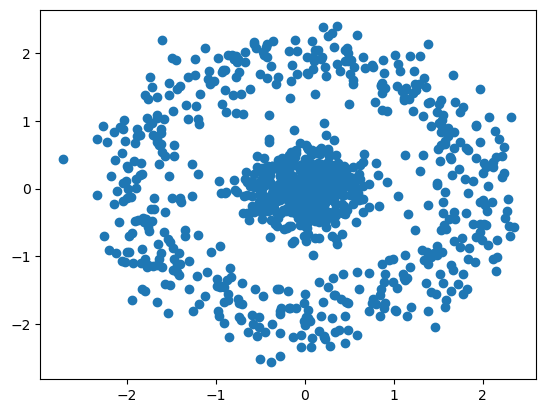

In [4]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
circles = scaler.fit_transform(circles)
plt.scatter(circles[:,0], circles[:,1])

# Baseline DBSCAN

Let's start with just a default DBSCAN to see how well it can solve this problem.

## Fit a Default DBSCAN and Plot the Clusters
#### Note: Plotting clusters is not possible with higher dimensional clustering! We do it here for demonstration only.

Since 'circles' is a NumPy array rather than a dataframe, we need to index into the two columns of the data we want to plot. They are the first and second arrays in the 2nd dimension of the array, or 'circles[:, 0]' and 'circles[:, 1]' respectively.

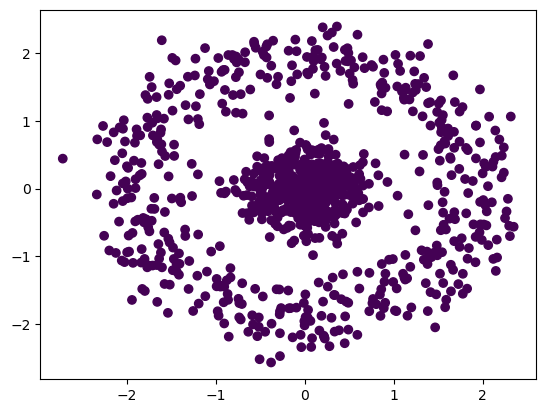

In [5]:
db = DBSCAN()
db.fit(circles)
plt.scatter(circles[:,0], circles[:, 1], c=db.labels_);

The default DBSCAN model clustered all of the points together into just one cluster. The default distance for DBSCAN in Scikit-Learn is 0.5 and the default for min_samples is 5. This means any points within 0.5 distance of each other will be clustered together and there only have to be 5 points clustered together to be considered a cluster.

---

# Tuning DBSCAN

## Choose min_samples

You will often need to use your judgment and domain knowledge about the data to choose the 'min_samples' hyperparameter. This parameter determines how many samples must be within epsilon distance of each other to be considered a cluster. If one or a group of samples has fewer than the 'min_samples' number of members, it will be considered noise rather than a cluster. You may need to adjust this number some to get the best results.

## Tune Epsilon

There are a few ways to tune the 'epsilon' argument once you have chosen your 'min_samples'. One way is to plot the distances between points from closest to farthest. More specifically we want to plot how many points are within a specific distance of another point.

Since there must be at least a 'min_samples' number of points to make a cluster, we want to plot the number of points that have their 'min_samples' farthest neighbor within 'epsilon' distance.

We can do this with the NearestNeighbor class in Scikit-Learn. This class will find the distances between all of the samples in our data and from that, we can return a list of each point and the distance to its 'k' number of neighbors. We set k = 'min_samples'.

### Create a List of Neighbors using NearestNeighbors

For our goals in this project, we want fairly large clusters. We want the outer circle to be one cluster and the inner cluster to be another. I'm going to set 'min_samples' to 20. A group of points must have 20 members to be a cluster.

In [6]:
min_samples = 20
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(circles)
distances, indices = neighbors.kneighbors(circles)
distances[:5]

array([[0.        , 0.03317269, 0.03684657, 0.03843617, 0.04554815,
        0.05305751, 0.06605228, 0.06636566, 0.06666659, 0.06791302,
        0.06838348, 0.07565918, 0.08259865, 0.08645387, 0.09075917,
        0.09190577, 0.09250838, 0.09312995, 0.09721234, 0.10403576],
       [0.        , 0.02141877, 0.02190873, 0.0525583 , 0.0620055 ,
        0.07445293, 0.07513315, 0.0866166 , 0.08930404, 0.08980387,
        0.0967244 , 0.10350215, 0.10375638, 0.10582193, 0.10678505,
        0.11096156, 0.11245924, 0.11473956, 0.11562288, 0.11716108],
       [0.        , 0.04395657, 0.28586353, 0.28688404, 0.30905073,
        0.30977458, 0.3160105 , 0.32505776, 0.32710425, 0.33892991,
        0.3436514 , 0.34500361, 0.34906258, 0.35135948, 0.36166579,
        0.36486062, 0.385714  , 0.39221766, 0.39319527, 0.39353591],
       [0.        , 0.05703624, 0.0919583 , 0.09911738, 0.11724588,
        0.12284202, 0.12447331, 0.1270101 , 0.1278932 , 0.12937459,
        0.13616776, 0.14093312, 0.14440086, 0

The 'distances' variable is an array of points and the distances to their 19 closest neighbors. The first point is the point referenced, so the first distance is always 0.

Next, we want to sort the 'distances' array by the distance to the 'min_samples' closest point. We choose min_samples-1 because NearestNeighbors.kneighbors() lists the reference point as the first neighbor, and it always has a distance of 0 to itself. You can see this in the output above. We will get an index error if we try to access the value at index=min_samples.

In [7]:
sorted_distances = np.sort(distances[:, min_samples-1])

Next, we can plot the sorted distances. This will show us what the distances are between each point and their kth neighbor and allow us to see how many samples have at least min_samples many neighbors within a certain distance. Let's take a look.

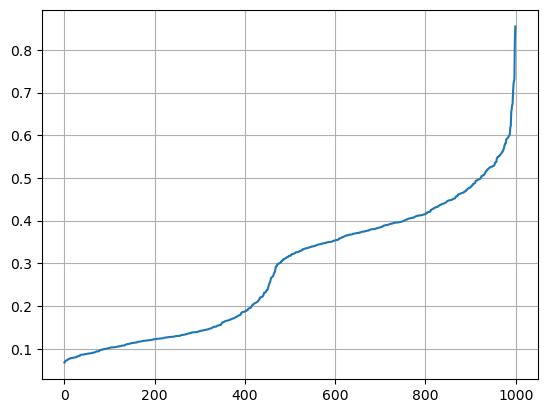

In [8]:
plt.plot(sorted_distances)
plt.grid();

The plot above shows us that there are about 400 samples with min_samples number of neighbors within a distance of 0.2, and the distance increases quickly (sloping upward on the y-axis) to about .32 before we see the next bunch of samples added. We can see groups of samples with min_samples number of neighbors at a certain distance where the line in the group levels off. We see another sharp rise in distances starting around a distance of 0.4.

We are looking for 'elbows' in this graph like we do for inertia. Using that strategy we might choose either 0.2 or 0.4. Our clusters overlap some, so we might want to try a lower epsilon, forcing points to be closer together to be clustered together. If our clusters were better defined then we might choose a more generous epsilon of 0.4.

Even though we can see that all points have min_samples number of neighbors within about 0.7, we don't want to set that as our epsilon. Remember that epsilon tells us how close two points need to be in a cluster together. If we chose 0.7, then all points might be in the same cluster. That's not what we want! We want to choose a value where most of the samples get clustered, but they don't all get clustered together.

In this case, our circles each have a large percentage of the samples in them, and we want to end up with just 2 clusters, so we are being strict with our min_samples by setting it at 20. A cluster is not a cluster unless it has at least 20 members! If we wanted more clusters we might reduce the value we use for min_samples. If we wanted to force samples to be closer together to qualify to be in the same cluster, we would reduce the eps (epsilon) hyperparameter.

### Fit the Tuned DBSCAN

## min_samples = 20 and eps = .2

In [9]:
# Instantiate & fit clustering - this is done in one step for DBSCAN
dbs = DBSCAN(eps = 0.2, min_samples = min_samples).fit(circles)

With our DBSCAN model fit, we can use it like our KMeans. We can analyze the clusters or use them for feature extraction. Since we are clustering two-dimensional data, we can plot them! Note that this would not be possible with higher dimensional data and DBSCAN models are difficult to evaluate numerically. Exploration of the clusters themselves and subject matter expertise would be the best ways to evaluate a higher dimensional clustering.

# **Plot DBSCAN Clusters. (Not possible with higher dimensional clustering)**
Since 'circles' is a NumPy array rather than a dataframe, we need to index into the two columns of the data we want to plot. They are the first and second arrays in the 2nd dimension of the array, or 'circles[:, 0]' and 'circles[:, 1]' respectively.

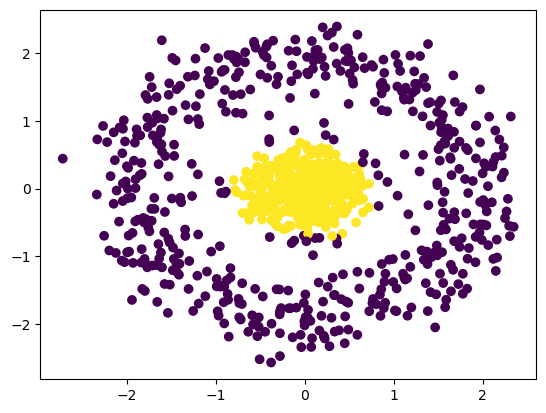

In [10]:
plt.scatter(circles[:,0], circles[:,1], c=dbs.labels_);

Our model clusters the circles perfectly, with the outer circle in yellow and the inner cluster in purple. While there are no clusters in the 'noise' cluster this time, samples that are not within the epsilon distance of a cluster are assigned to cluster -1, the 'noise' cluster.
```
min_samples = 20 and eps = .4
```
We could also try an epsilon of 0.4 for comparison since that is where the other elbow in the graph appeared. This would let points farther apart still be clustered together.

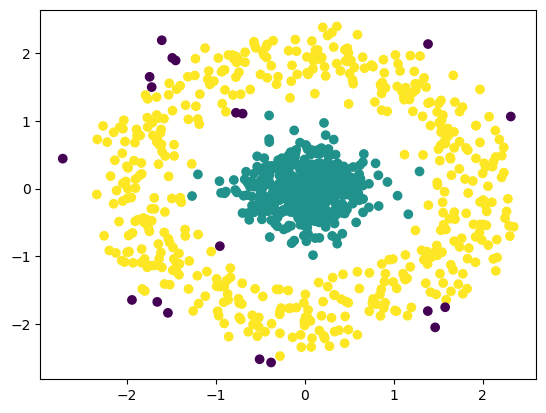

In [11]:
db = DBSCAN(eps=0.4, min_samples=min_samples).fit(circles)
plt.scatter(circles[:,0], circles[:,1], c=db.labels_)

With the more generous epsilon value, we still get a pretty good clustering, but some points have been assigned as 'noise', which is denoted in the DBSCAN labels with the value '-1'. The turquoise is one cluster and the yellow is the other. The purple now represents the 'noise', or unclustered samples. More of the samples around the edges of the center circle have been included in that center cluster. This is because the required distance for cluster inclusion was reduced.

# DBSCAN vs KMeans
Notice that while KMeans will cluster points into roughly spherical clusters because clusters are defined by their distance from a centroid, DBSCAN can create non-spherical clusters, like the ones above. The outer yellow circle is not a cluster that KMeans would ever make because there is no centroid that all points in the outer circle would be closer to than the points in the inner circle. KMeans also assigns **all** points to a cluster, whereas DBSCAN can leave some points out of clustering.

---